# EDA

This notebook contains some code for exploratory data analysis on the Million Song Dataset. The task is to add automatic tags to songs based on 

In [1]:
import h5py
import json
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import pandas as pd
from tqdm.notebook import tqdm

## Fetch data

Execute only first time.

In [ ]:
!mkdir data/

In [ ]:
# Get the Million Song Subset
!wget -P data/ http://labrosa.ee.columbia.edu/~dpwe/tmp/millionsongsubset.tar.gz
!tar -xzvf data/millionsongsubset.tar.gz -C data/

In [11]:
# Get the LastFM data for the subset
!wget -P data/ http://millionsongdataset.com/sites/default/files/lastfm/lastfm_subset.zip
!unzip data/lastfm_subset.zip -d data/

--2024-07-22 14:25:26--  http://millionsongdataset.com/sites/default/files/lastfm/lastfm_subset.zip
Resolving millionsongdataset.com (millionsongdataset.com)... 172.104.14.177
Connecting to millionsongdataset.com (millionsongdataset.com)|172.104.14.177|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12944659 (12M) [application/zip]
Saving to: ‘data/lastfm_subset.zip.1’

lastfm_subset.zip.1 100%[===================>]  12,34M   635KB/s    in 25s     

2024-07-22 14:25:52 (496 KB/s) - ‘data/lastfm_subset.zip.1’ saved [12944659/12944659]

Archive:  data/lastfm_subset.zip
   creating: data/lastfm_subset/
   creating: data/lastfm_subset/A/
   creating: data/lastfm_subset/A/C/
   creating: data/lastfm_subset/A/C/C/
  inflating: data/lastfm_subset/A/C/C/TRACCUS128F92E1FEB.json  
  inflating: data/lastfm_subset/A/C/C/TRACCVZ128F4291A8A.json  
  inflating: data/lastfm_subset/A/C/C/TRACCXJ128F92E984B.json  
  inflating: data/lastfm_subset/A/C/C/TRACCVN128F92DAE3D.json  
 

In [12]:
!tree data/

data/
├── lastfm_subset
│   ├── A
│   │   ├── A
│   │   │   ├── A
│   │   │   │   ├── TRAAAAW128F429D538.json
│   │   │   │   ├── TRAAABD128F429CF47.json
│   │   │   │   ├── TRAAADZ128F9348C2E.json
│   │   │   │   ├── TRAAAEF128F4273421.json
│   │   │   │   ├── TRAAAFD128F92F423A.json
│   │   │   │   ├── TRAAAMO128F1481E7F.json
│   │   │   │   ├── TRAAAMQ128F1460CD3.json
│   │   │   │   ├── TRAAAPK128E0786D96.json
│   │   │   │   ├── TRAAARJ128F9320760.json
│   │   │   │   ├── TRAAAVG12903CFA543.json
│   │   │   │   └── TRAAAVO128F93133D4.json
│   │   │   ├── B
│   │   │   │   ├── TRAABDL12903CAABBA.json
│   │   │   │   ├── TRAABJL12903CDCF1A.json
│   │   │   │   ├── TRAABJV128F1460C49.json
│   │   │   │   ├── TRAABLR128F423B7E3.json
│   │   │   │   ├── TRAABNV128F425CEE1.json
│   │   │   │   ├── TRAABRB128F9306DD5.json
│   │   │   │   ├── TRAABVM128F92CA9DC.json
│   │   │   │   ├── TRAABXG128F9318EBD.json
│   │   │   │   ├── TRAABYN12903CFD305.json
│   │   │   │   └── TRAABYW128F42445

## Inspect a single file

In [8]:
PATH = "data/MillionSongSubset/A/A/A/TRAAAAW128F429D538.h5"

In [9]:
# Get an idea of the structure of the EchoNest data
with h5py.File(PATH, "r") as f:
    print("Keys:", f.keys()) 
    print("Analysis:", f['analysis'].keys())
    print("Metadata:", f['metadata'].keys())
    print("Musicbrainz:", f['musicbrainz'].keys())

Keys: <KeysViewHDF5 ['analysis', 'metadata', 'musicbrainz']>
Analysis: <KeysViewHDF5 ['bars_confidence', 'bars_start', 'beats_confidence', 'beats_start', 'sections_confidence', 'sections_start', 'segments_confidence', 'segments_loudness_max', 'segments_loudness_max_time', 'segments_loudness_start', 'segments_pitches', 'segments_start', 'segments_timbre', 'songs', 'tatums_confidence', 'tatums_start']>
Metadata: <KeysViewHDF5 ['artist_terms', 'artist_terms_freq', 'artist_terms_weight', 'similar_artists', 'songs']>
Musicbrainz: <KeysViewHDF5 ['artist_mbtags', 'artist_mbtags_count', 'songs']>


In [9]:
PATH = "data/lastfm_subset/A/A/A/TRAAAAW128F429D538.json"

In [10]:
with open(PATH, 'r') as f:
    data = json.load(f)
    print(data.keys())
    print(data['tags'])

dict_keys(['artist', 'timestamp', 'similars', 'tags', 'track_id', 'title'])
[['Bay Area', '100'], ['hieroglyiphics', '100'], ['classic', '50'], ['Hip-Hop', '50'], ['stream', '50'], ['OG', '50'], ['1979-2006: A Hip-Hop Odyssey - 800 Tracks In A 48 Minute Mix', '50'], ['heiroglyphics', '50'], ['oaksterdamn', '50'], ['heard on Pandora', '0']]


## Filtered list of genres

To filter the available tags for genre identifiers, we use an external source of spotify data and normalize it.

In [2]:
!wget -P data/ https://gist.githubusercontent.com/andytlr/4104c667a62d8145aa3a/raw/2d044152bcacf98d401b71df2cb67fade8e490c9/spotify-genres.md

--2024-07-24 11:14:09--  https://gist.githubusercontent.com/andytlr/4104c667a62d8145aa3a/raw/2d044152bcacf98d401b71df2cb67fade8e490c9/spotify-genres.md
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22357 (22K) [text/plain]
Saving to: ‘data/spotify-genres.md.1’

spotify-genres.md.1 100%[===================>]  21,83K  --.-KB/s    in 0,01s   

2024-07-24 11:14:09 (1,61 MB/s) - ‘data/spotify-genres.md.1’ saved [22357/22357]



In [3]:
with open('data/spotify-genres.md', 'r') as f:
    genre_lines = f.readlines()

In [4]:
def normalize_genre(genre_str) -> str:
    return genre_str.lower().replace("-", " ")

In [5]:
SPOTIFY_GENRES = []
for line in genre_lines[4:]:
    genre = line.strip()[3:]
    SPOTIFY_GENRES.append(normalize_genre(genre))

In [6]:
SPOTIFY_GENRES[:10]

['a cappella',
 'abstract',
 'abstract beats',
 'abstract hip hop',
 'abstract idm',
 'abstractro',
 'accordion',
 'acid house',
 'acid jazz',
 'acid techno']

## Extracting genre labels from LastFM data

The target variable will be the genre. We can take these from the lastfm json files. As we can see, there are many tags that are not necessarily related to genre. We'll filter those out by finding a comprehensive list of genre names and checking whether the tag is part of it.

In [6]:
def get_genres(track_data: dict) -> list[str]:
    lastfm_tags = [normalize_genre(tag[0]) for tag in track_data['tags']]
    genre_tags = [tag for tag in lastfm_tags if tag in genres]
    return genre_tags

In [11]:
get_genres(data)

['hip hop']

In [13]:
# Check for a couple of tracks
for path in list(Path("data/lastfm_subset").glob("*/*/*/*.json"))[:20]:
    with open(path, 'r') as f:
        data = json.load(f)
        print(data['tags'])
        print(get_genres(data))
        print()

[['pop', '100'], ['80s', '82'], ['70s', '64'], ['classic rock', '54'], ['soft rock', '33'], ['soul', '29'], ['rock', '27'], ['male vocalists', '25'], ['oldies', '13'], ['catchy', '11'], ['yacht rock', '9'], ['usa hot 100 number one hit', '9'], ["70's", '7'], ['77davez-all-tracks', '7'], ['Blue-Eyed Soul', '5'], ['RB', '5'], ['philly soul', '5'], ['pop rock', '5'], ['Mellow', '5'], ['favorites', '5'], ['fun', '5'], ['easy listening', '3'], ['ws2010 - 17', '3'], ['rich girl-hall oates', '3'], ['1977 songs', '3'], ['AM Gold', '3'], ['1976', '3'], ['old but good', '3'], ['classic', '3'], ['american', '3'], ['favorite songs', '3'], ['franziska loves it', '1'], ['RichGirl', '1'], ['Philipp likes it', '1'], ['favorite by this duo', '1'], ['green tag', '1'], ['Zara', '1'], ['vocalization', '1'], ['The REALLY loved', '1'], ['Philadelphia soul', '1'], ['Whiplash', '1'], ['albatross', '1'], ['halloates', '1'], ['hip hop sample', '1'], ['number one hits', '1'], ['soft rock pop', '1'], ['Classic Hi

There are many tracks for which no genre tags are found. That's fine, we will remove them from the training & evaluation data. The number of tags differs a lot per track, some have many, others have none. As a result, the number of genre tags differs quite a bit. We will take this into account for our evaluation metrics. First, let's plot the distribution of valid genre tags.

In [12]:
# Iterate over all tracks
# Keep a mapping of track: genre tags
track_genres_map = {}

for path in list(Path("data/lastfm_subset").glob("*/*/*/*.json")):
    with open(path, 'r') as f:
        data = json.load(f)
        track_genres = get_genres(data)
        track_genres_map[path.stem] = track_genres

In [13]:
len(track_genres_map)

9330

28


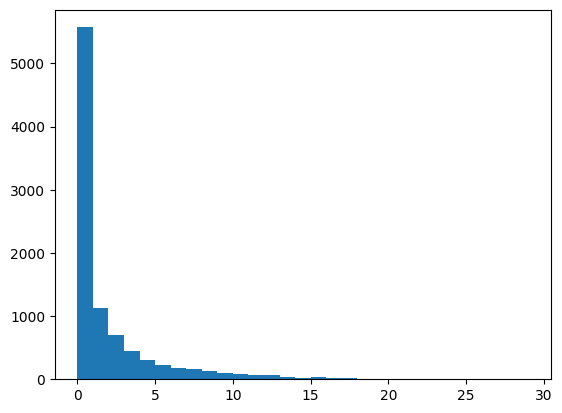

In [21]:
num_genres_count = [len(v) for _, v in track_genres_map.items()]
print(max(num_genres_count))
plt.hist(num_genres_count, bins=np.arange(30))
plt.show()

In [23]:
genres_counter = Counter()
for _, v in track_genres_map.items():
    genres_counter.update(v)

In [38]:
genres_counter.most_common(100)

[('rock', 1161),
 ('pop', 746),
 ('hip hop', 530),
 ('alternative rock', 414),
 ('classic rock', 385),
 ('blues', 366),
 ('hard rock', 358),
 ('metal', 340),
 ('electronic', 339),
 ('singer songwriter', 309),
 ('punk', 304),
 ('soul', 265),
 ('jazz', 236),
 ('indie rock', 225),
 ('pop rock', 217),
 ('country', 217),
 ('blues rock', 214),
 ('rap', 206),
 ('electronica', 184),
 ('folk', 179),
 ('soundtrack', 170),
 ('hardcore', 167),
 ('experimental', 162),
 ('easy listening', 152),
 ('reggae', 151),
 ('ambient', 145),
 ('funk', 141),
 ('latin', 137),
 ('emo', 136),
 ('progressive rock', 129),
 ('romantic', 118),
 ('post punk', 112),
 ('new wave', 109),
 ('soft rock', 104),
 ('downtempo', 97),
 ('electro', 94),
 ('grunge', 88),
 ('death metal', 87),
 ('pop punk', 86),
 ('post hardcore', 85),
 ('world', 85),
 ('indie pop', 82),
 ('britpop', 80),
 ('black metal', 77),
 ('folk rock', 76),
 ('lounge', 73),
 ('house', 73),
 ('new age', 73),
 ('techno', 72),
 ('underground hip hop', 71),
 ('ha

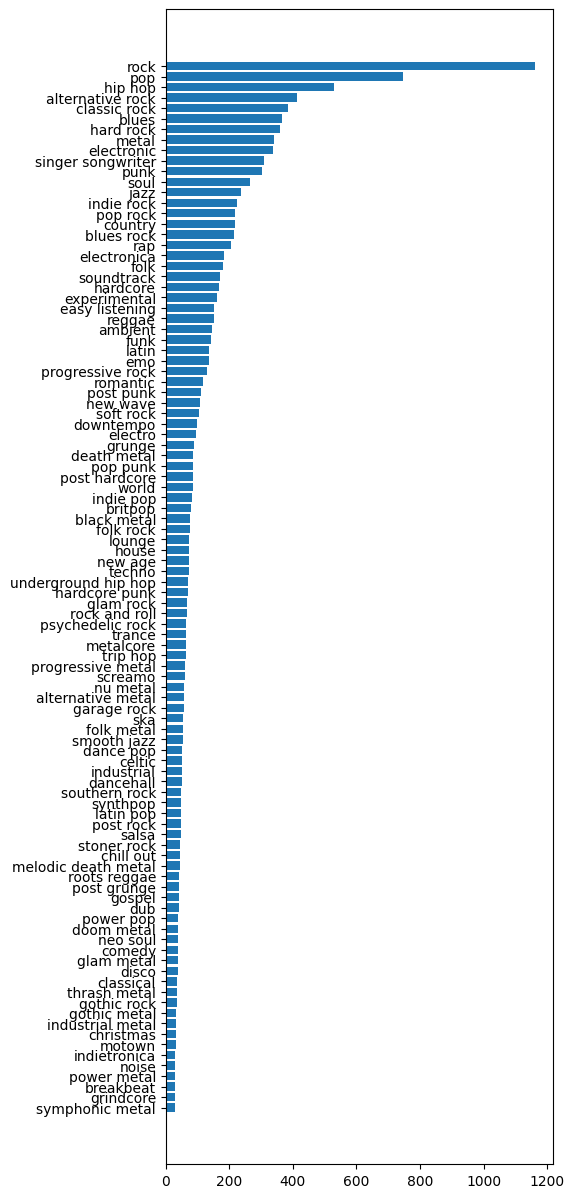

In [39]:
top_genres, top_genres_count = zip(*genres_counter.most_common())
fig, ax = plt.subplots(figsize=(5,15))
ax.barh(top_genres[:100], top_genres_count[:100])
ax.invert_yaxis()  # labels read top-to-bottom
plt.show()

In [42]:
# There are a large number of genres that appear very rarely.
[(k, v) for k, v in genres_counter.items() if v < 5]

[('turkish pop', 2),
 ('hardstyle', 3),
 ('deep vocal house', 2),
 ('disco house', 4),
 ('no wave', 4),
 ('harp', 4),
 ('geek rock', 4),
 ('christian hardcore', 2),
 ('healing', 3),
 ('rock gaucho', 1),
 ('rap metal', 4),
 ('horrorcore', 4),
 ('hardcore hip hop', 1),
 ('electropunk', 3),
 ('funky breaks', 1),
 ('new orleans blues', 2),
 ('christian christmas', 3),
 ('jerk', 2),
 ('mod revival', 4),
 ('southern hip hop', 2),
 ('zydeco', 3),
 ('gothic doom', 1),
 ('new age piano', 1),
 ('french folk', 1),
 ('jazz metal', 2),
 ('neo psychedelic', 3),
 ('abstract', 4),
 ('beatdown', 2),
 ('steampunk', 2),
 ('drone metal', 1),
 ('texas country', 4),
 ('j rock', 3),
 ('pop rap', 4),
 ('merengue', 3),
 ('cowpunk', 2),
 ('colombian rock', 1),
 ('chillwave', 1),
 ('baroque', 2),
 ('deathgrind', 3),
 ('freakbeat', 2),
 ('contemporary country', 4),
 ('tribute', 4),
 ('tzadik', 1),
 ('choral', 1),
 ('schlager', 4),
 ('cello', 4),
 ('dub techno', 2),
 ('detroit techno', 1),
 ('minimal dub', 1),
 ('

### Genre labels conclusions

* The genre labels follow a long-tail distribution. We will filter out any genres that do not appear in the top K (say 100)
* Many tracks do not have any genre labels assigned. We will discard tracks from the training data that have empty list of genres after filtering.
* The task will be treated as multi-label classification. 

## Feature selection

In [33]:
song_file = "data/MillionSongSubset/A/X/L/TRAXLZU12903D05F94.h5" 

For this task we will only use the analysis features, to simulate the case where we receive the raw audio, extract features and then classify genre, without additional metadata about the artist.

We can extract the genres from the h5 files directly instead of using lastfm data.

In [60]:
with h5py.File(song_file, "r") as f:
    tags = [s.decode('UTF-8') for s in f['metadata']['artist_terms'][()]]
    genre_tags = [normalize_genre(tag) for tag in tags]
    genre_tags = [tag for tag in genre_tags if tag in genres]
    print(genre_tags)

['dance pop', 'rock', 'pop', 'soul']


In [34]:
# List all keys per group
with h5py.File(song_file, "r") as f:
    print("Keys:", f.keys()) 
    print("Analysis:", f['analysis'].keys())
    print("Metadata:", f['metadata'].keys())
    print("Musicbrainz:", f['musicbrainz'].keys())    

Keys: <KeysViewHDF5 ['analysis', 'metadata', 'musicbrainz']>
Analysis: <KeysViewHDF5 ['bars_confidence', 'bars_start', 'beats_confidence', 'beats_start', 'sections_confidence', 'sections_start', 'segments_confidence', 'segments_loudness_max', 'segments_loudness_max_time', 'segments_loudness_start', 'segments_pitches', 'segments_start', 'segments_timbre', 'songs', 'tatums_confidence', 'tatums_start']>
Metadata: <KeysViewHDF5 ['artist_terms', 'artist_terms_freq', 'artist_terms_weight', 'similar_artists', 'songs']>
Musicbrainz: <KeysViewHDF5 ['artist_mbtags', 'artist_mbtags_count', 'songs']>


In [55]:
# List tags of a song
with h5py.File(song_file, "r") as f:
    print([s.decode('UTF-8') for s in f['musicbrainz']['artist_mbtags'][()]])
    print([s.decode('UTF-8') for s in f['metadata']['artist_terms'][()]])

['uk', 'british', 'english', 'classic pop and rock']
['dance pop', 'rock', 'pop', 'england', 'adult contemporary', 'ballad', 'club', 'classic', 'male', 'cover', 'soul', '80s']


In [36]:
with h5py.File(song_file, "r") as f:
    for analysis_key in f['analysis'].keys():
        print(analysis_key)
        print(f['analysis'][analysis_key])
    print("============")
    print(f['analysis']['songs'].dtype)
    print("============")

bars_confidence
<HDF5 dataset "bars_confidence": shape (99,), type "<f8">
bars_start
<HDF5 dataset "bars_start": shape (99,), type "<f8">
beats_confidence
<HDF5 dataset "beats_confidence": shape (397,), type "<f8">
beats_start
<HDF5 dataset "beats_start": shape (397,), type "<f8">
sections_confidence
<HDF5 dataset "sections_confidence": shape (10,), type "<f8">
sections_start
<HDF5 dataset "sections_start": shape (10,), type "<f8">
segments_confidence
<HDF5 dataset "segments_confidence": shape (935,), type "<f8">
segments_loudness_max
<HDF5 dataset "segments_loudness_max": shape (935,), type "<f8">
segments_loudness_max_time
<HDF5 dataset "segments_loudness_max_time": shape (935,), type "<f8">
segments_loudness_start
<HDF5 dataset "segments_loudness_start": shape (935,), type "<f8">
segments_pitches
<HDF5 dataset "segments_pitches": shape (935, 12), type "<f8">
segments_start
<HDF5 dataset "segments_start": shape (935,), type "<f8">
segments_timbre
<HDF5 dataset "segments_timbre": shap

In [31]:
# List of song metadata
with h5py.File(song_file, "r") as f:
    print(f['analysis']['songs'].dtype)
    print(f['analysis']['songs']['danceability'][0])

[('analysis_sample_rate', '<i4'), ('audio_md5', 'S32'), ('danceability', '<f8'), ('duration', '<f8'), ('end_of_fade_in', '<f8'), ('energy', '<f8'), ('idx_bars_confidence', '<i4'), ('idx_bars_start', '<i4'), ('idx_beats_confidence', '<i4'), ('idx_beats_start', '<i4'), ('idx_sections_confidence', '<i4'), ('idx_sections_start', '<i4'), ('idx_segments_confidence', '<i4'), ('idx_segments_loudness_max', '<i4'), ('idx_segments_loudness_max_time', '<i4'), ('idx_segments_loudness_start', '<i4'), ('idx_segments_pitches', '<i4'), ('idx_segments_start', '<i4'), ('idx_segments_timbre', '<i4'), ('idx_tatums_confidence', '<i4'), ('idx_tatums_start', '<i4'), ('key', '<i4'), ('key_confidence', '<f8'), ('loudness', '<f8'), ('mode', '<i4'), ('mode_confidence', '<f8'), ('start_of_fade_out', '<f8'), ('tempo', '<f8'), ('time_signature', '<i4'), ('time_signature_confidence', '<f8'), ('track_id', 'S32')]
0.0


## Extracting MFCC-like features

These describe the source audio and could be used to train a model for genre classification directly. 

(544, 12)


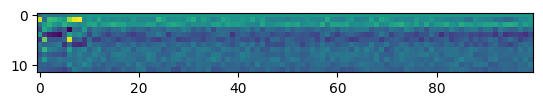

In [29]:
with h5py.File(song_file, "r") as f:
    segments_timbre = f['analysis']['segments_timbre'][()]
    print(segments_timbre.shape)
    plt.imshow(segments_timbre[:100].T)
    plt.show()

## Building a pandas dataframe of featuers & labels

In [7]:
FEATURE_NAMES = [
    "danceability", "duration", "energy", "key", "loudness", "mode", "tempo"
]
def get_features(h5_file, feature_names = FEATURE_NAMES):
    feature_values = []
    for feature_name in feature_names:
        feature_value = h5_file['analysis']['songs'][feature_name][0]
        feature_values.append(feature_value)
    return feature_values

def get_genres(h5_file, genre_filter: list[str] = SPOTIFY_GENRES) -> list[str]:
    tags = [s.decode('UTF-8') for s in h5_file['metadata']['artist_terms'][()]]
    genre_tags = [normalize_genre(tag) for tag in tags]
    genre_tags = [tag for tag in genre_tags if tag in genre_filter]
    return genre_tags

In [9]:
song_file = "data/MillionSongSubset/A/X/L/TRAXLZU12903D05F94.h5" 

with h5py.File(song_file, "r") as f:
    print(get_features(f))
    print(get_genres(f))

[np.float64(0.0), np.float64(211.69587), np.float64(0.0), np.int32(1), np.float64(-7.75), np.int32(1), np.float64(113.359)]
['dance pop', 'rock', 'pop', 'soul']


In [18]:
data = []
for song_file in tqdm(list(Path('.').glob("data/MillionSongSubset/*/*/*/*.h5"))):
    track_id = song_file.stem
    with h5py.File(song_file, "r") as f:
        features = get_features(f)
        genres = get_genres(f)
    data.append([
        track_id,
        *features,
        genres
    ])

  0%|          | 0/10000 [00:00<?, ?it/s]

In [19]:
df = pd.DataFrame(data, columns=['track_id', *FEATURE_NAMES, 'genres'])

In [20]:
df.head()

,track_id,danceability,duration,energy,key,loudness,mode,tempo,genres
0,TRBGGLA128F149C2EB,0.0,262.34730,0.0,11,-7.673,0,89.912,"[uk garage, hip hop, gangster rap, rap, electr..."
1,TRBGGRU12903CAAA2D,0.0,159.94730,0.0,0,-32.535,1,72.357,"[country rock, western swing, gypsy jazz, sing..."
2,TRBGGOS128F9307FC5,0.0,250.77506,0.0,10,-6.188,0,177.963,"[neo soul, hip hop, vocal jazz, progressive ho..."
3,TRBGGTE128F424ECBC,0.0,159.26812,0.0,0,-10.599,0,80.945,"[ccm, christian rock, gospel, blues, pop, soul..."
4,TRBGGOT128F932DC65,0.0,171.98975,0.0,2,-8.002,1,181.002,"[progressive house, electronic, latin]"


In [21]:
df.describe()

,danceability,duration,energy,key,loudness,mode,tempo
count,10000.0,10000.000000,10000.0,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.0,238.507518,0.0,5.276100,-10.485668,0.691100,122.915449
std,0.0,114.137514,0.0,3.554087,5.399788,0.462063,35.184412
min,0.0,1.044440,0.0,0.000000,-51.643000,0.000000,0.000000
25%,0.0,176.032200,0.0,2.000000,-13.163250,0.000000,96.965750
50%,0.0,223.059140,0.0,5.000000,-9.380000,1.000000,120.161000
75%,0.0,276.375060,0.0,8.000000,-6.532500,1.000000,144.013250
max,0.0,1819.767710,0.0,11.000000,0.566000,1.000000,262.828000
